In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
import re

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database

con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = "SELECT * FROM payments WHERE provider_type = 'Medical Oncology'"
payments = pd.read_sql_query(q, con=con)

In [4]:
# number of distinct doctors in payments
len(payments['npi'].unique())

2795

In [5]:
payments.shape

(53502, 26)

In [6]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53502 entries, 0 to 53501
Data columns (total 26 columns):
npi                                 53502 non-null object
nppes_provider_last_org_name        53502 non-null object
nppes_provider_first_name           53502 non-null object
nppes_provider_mi                   40248 non-null object
nppes_credentials                   53040 non-null object
nppes_provider_gender               53502 non-null object
nppes_entity_code                   53502 non-null object
nppes_provider_street1              53502 non-null object
nppes_provider_street2              26598 non-null object
nppes_provider_city                 53502 non-null object
nppes_provider_zip                  53502 non-null object
nppes_provider_state                53502 non-null object
nppes_provider_country              53502 non-null object
provider_type                       53502 non-null object
medicare_participation_indicator    53502 non-null object
place_of_service     

In [7]:
q = "SELECT * FROM summary WHERE provider_type = 'Medical Oncology'"
summary = pd.read_sql_query(q, con=con)
print(summary.shape)

(2849, 70)


In [8]:
summary.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,beneficiary_cc_depr_percent,beneficiary_cc_diab_percent,beneficiary_cc_hyperl_percent,beneficiary_cc_hypert_percent,beneficiary_cc_ihd_percent,beneficiary_cc_ost_percent,beneficiary_cc_raoa_percent,beneficiary_cc_schiot_percent,beneficiary_cc_strk_percent,beneficiary_average_risk_score
0,1003019571,SEHGAL,RAJESH,None,MD,M,I,400 OXFORD DR,SUITE 102,MONROEVILLE,...,29.0,32.0,52.0,72.0,48.0,13.0,43.0,10.0,11.0,2.2866
1,1003087768,BATUS,MARTA,None,MD,F,I,1725 W HARRISON ST,SUITE 809,CHICAGO,...,23.0,37.0,54.0,71.0,46.0,6.0,38.0,6.0,10.0,2.2670
2,1003166042,FINE,HOWARD,A,M.D.,M,I,160 E 34TH ST,None,NEW YORK,...,NaN,NaN,41.0,55.0,NaN,NaN,NaN,NaN,NaN,1.8537
3,1003805409,WILLIAMS,STEPHANIE,F,MD,F,I,145 MICHIGAN ST NE,SUITE 5200,GRAND RAPIDS,...,37.0,NaN,53.0,60.0,40.0,NaN,53.0,NaN,NaN,3.7059
4,1003807645,LUNIN,SCOTT,D,M.D.,M,I,3085 BOBCAT VILLAGE CENTER RD,None,NORTH PORT,...,19.0,27.0,59.0,69.0,43.0,12.0,40.0,2.0,5.0,1.9320


In [9]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2849 entries, 0 to 2848
Data columns (total 70 columns):
npi                                 2849 non-null object
nppes_provider_last_org_name        2849 non-null object
nppes_provider_first_name           2849 non-null object
nppes_provider_mi                   2015 non-null object
nppes_credentials                   2782 non-null object
nppes_provider_gender               2849 non-null object
nppes_entity_code                   2849 non-null object
nppes_provider_street1              2849 non-null object
nppes_provider_street2              1362 non-null object
nppes_provider_city                 2849 non-null object
nppes_provider_zip                  2849 non-null object
nppes_provider_state                2849 non-null object
nppes_provider_country              2849 non-null object
provider_type                       2849 non-null object
medicare_participation_indicator    2849 non-null object
number_of_hcpcs                     28

In [10]:
payments.drop_duplicates(['npi']).head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_allowed_amt,average_submitted_chrg_amt,average_medicare_payment_amt,average_medicare_standard_amt
0,1003019571,SEHGAL,RAJESH,None,MD,M,I,400 OXFORD DR,SUITE 102,MONROEVILLE,...,36415,Insertion of needle into vein for collection o...,N,101.0,52.0,101.0,3.00,20.00,2.94,2.94
20,1003087768,BATUS,MARTA,None,MD,F,I,1725 W HARRISON ST,SUITE 809,CHICAGO,...,99204,"New patient office or other outpatient visit, ...",N,15.0,15.0,15.0,143.37,289.00,112.40,103.36
28,1003166042,FINE,HOWARD,A,M.D.,M,I,160 E 34TH ST,None,NEW YORK,...,99212,Established patient office or other outpatient...,N,15.0,13.0,15.0,28.28,150.00,22.17,20.08
31,1003805409,WILLIAMS,STEPHANIE,F,MD,F,I,145 MICHIGAN ST NE,SUITE 5200,GRAND RAPIDS,...,99214,Established patient office or other outpatient...,N,39.0,16.0,39.0,77.51,146.49,57.42,63.08
34,1003807645,LUNIN,SCOTT,D,M.D.,M,I,3085 BOBCAT VILLAGE CENTER RD,None,NORTH PORT,...,36415,Insertion of needle into vein for collection o...,N,1746.0,645.0,1746.0,3.00,9.00,2.94,2.94


Of the payments, how many are related to medicare part B and how many are not?

HCPCS = Healthcare Common Procedure Coding System 

hcpcs_drug_indicator - identify whether the HCPCS product/service is a drug as defined from the Medicare Part B Drug ASP list. In addition, HCPCS descriptions have been expanded to include consumer friendly descriptions
provided by the AMA for CPT codes (numeric HCPCS codes) and long form descriptions for the CMS
Level II codes (alpha-numeric HCPCS codes)

In [11]:
payments.groupby(['hcpcs_drug_indicator'])['npi'].count()

hcpcs_drug_indicator
N    40477
Y    13025
Name: npi, dtype: int64

In [12]:
# what kind of medicare part B drugs are there?
payments.loc[payments['hcpcs_drug_indicator'] == 'Y', ['hcpcs_code','hcpcs_description']].head()

,hcpcs_code,hcpcs_description
17,J1100,"Injection, dexamethasone sodium phosphate, 1mg"
18,J1200,"Injection, diphenhydramine hcl, up to 50 mg"
19,J1626,"Injection, granisetron hydrochloride, 100 mcg"
95,J0641,"Injection, levoleucovorin calcium, 0.5 mg"
96,J0885,"Injection, epoetin alfa, (for non-esrd use), 1..."


How many distinct hcpcs codes are there in the dataset?

In [13]:
payments['hcpcs_code'].value_counts().size

635

In [14]:
counts_per_code = payments['hcpcs_code'].value_counts().reset_index(name='count')
counts_per_code.rename(columns={'index': 'hcpcs_code'}, inplace=True)
counts_per_code.head()

,hcpcs_code,count
0,99214,2761
1,99213,2108
2,99215,1892
3,99205,1856
4,99232,1478


In [15]:
pd.set_option('max_colwidth', 80)
counts_per_code = (counts_per_code.merge(payments[['hcpcs_code', 'hcpcs_description','hcpcs_drug_indicator']],
                       on='hcpcs_code', sort=False)
                   .drop_duplicates())
counts_per_code.head(30)

,hcpcs_code,count,hcpcs_description,hcpcs_drug_indicator
0,99214,2761,"Established patient office or other outpatient, visit typically 25 minutes",N
2761,99213,2108,"Established patient office or other outpatient visit, typically 15 minutes",N
4869,99215,1892,"Established patient office or other outpatient, visit typically 40 minutes",N
6761,99205,1856,"New patient office or other outpatient visit, typically 60 minutes",N
8617,99232,1478,"Subsequent hospital inpatient care, typically 25 minutes per day",N
10095,99233,1314,"Subsequent hospital inpatient care, typically 35 minutes per day",N
11409,99223,1201,"Initial hospital inpatient care, typically 70 minutes per day",N
12610,99204,1040,"New patient office or other outpatient visit, typically 45 minutes",N
13650,96372,987,"Injection beneath the skin or into muscle for therapy, diagnosis, or prevention",N
14637,96413,982,Infusion of chemotherapy into a vein up to 1 hour,N


What is the distribution of counts per code?

In [16]:
counts_per_code.query("hcpcs_drug_indicator=='Y'").head(30)

,hcpcs_code,count,hcpcs_description,hcpcs_drug_indicator
15619,J1100,932,"Injection, dexamethasone sodium phosphate, 1mg",Y
22579,J1200,801,"Injection, diphenhydramine hcl, up to 50 mg",Y
23380,J2469,738,"Injection, palonosetron hcl, 25 mcg",Y
26510,J2505,528,"Injection, pegfilgrastim, 6 mg",Y
28082,J7030,501,"Infusion, normal saline solution , 1000 cc",Y
28583,J9045,500,"Injection, carboplatin, 50 mg",Y
29083,J3489,496,"Injection, zoledronic acid, 1 mg",Y
33503,J3420,393,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg",Y
35021,J0897,365,"Injection, denosumab, 1 mg",Y
35386,J9265,359,"Injection, paclitaxel, 30 mg",Y


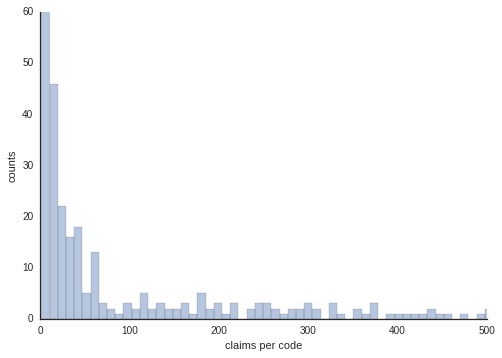

In [17]:
g = sns.distplot(counts_per_code['count'], kde=False, bins=300)
g.set(xlim=(0,500), ylim=(0, 60), xlabel='claims per code', ylabel='counts')
sns.despine()

How many distinct hcpcs codes are associated with Medicare part B drugs?

In [18]:
payments.query("hcpcs_drug_indicator=='Y'").groupby(['hcpcs_drug_indicator','hcpcs_code']).count().shape

(143, 24)

    143 / 635 = 22.5% of the hcpcs codes in the dataset

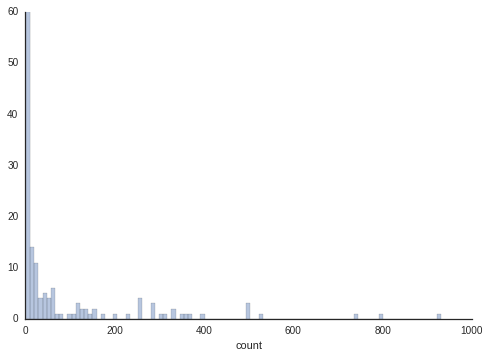

In [19]:
# distribution of counts per drug codes?
g = sns.distplot(counts_per_code.query("hcpcs_drug_indicator=='Y'")['count'], kde=False, bins=100)
#g.set(xlim=(0,500), ylim=(0, 60), xlabel='claims per drug B code', ylabel='counts')
sns.despine()

The most common drug (dexamethasone) is included as a claim by >900 doctors.  However, a number of drugs are also claimed very infrequently, as witnessed by the spike in the histogram near count of 1.  These drugs are more likely to be highly specific, not something that is routinely prescribed to counteract side effects.

## Medicare Part B drugs
- J0000 - J8499: drugs other than chemotherapy
- J8521 - J9999: chemotherapy drugs

In [20]:
# How many drugs are chemo/non chemo or neither?
def drug_category_count(drugs):
    """Count drugs per category, A,B,C
    input - list of hcpcs codes for drugs
    returns - list of drugs per category and error list containing drugs that don't fall in any category
    
    # A : J0000 - J8499 --- drugs other than chemo
    # B : J8521 - J9999 --- chemo drugs
    # C : Doesn't begin with 'J'
    """
    A = []
    B = []
    C = []
    
    countA = 0
    countB = 0
    countC = 0
    errorlist = []  # list of drugs that don't fall in either category
    for d in drugs:
        if d[0].upper() == 'J':
            if int(d[1:]) >= 0 and int(d[1:]) <= 8499:
                countA += 1
                A.append(d)
            elif int(d[1:]) >= 8521 and int(d[1:]) <= 9999:
                countB += 1
                B.append(d)
            else:
                errorlist.append(d)
        else:
            countC += 1
            C.append(d)
    
    print("drugs other than chemo: {0}; \n chemo drugs: {1}; \n drugs that don't start with J: {2}".format(countA, countB, countC))
    return A, B, C, errorlist


In [21]:
nonchemo_drugs, chemo_drugs, other_drugs, error_drugs = (drug_category_count(counts_per_code.
                                                                             query("hcpcs_drug_indicator=='Y'").
                                                                             iloc[:,0]))

drugs other than chemo: 90; 
 chemo drugs: 31; 
 drugs that don't start with J: 22


In [22]:
len(error_drugs)

0

In [23]:
## make them strings
nonchemo_drugs = [str(x) for x in nonchemo_drugs]
chemo_drugs = [str(x) for x in chemo_drugs]
other_drugs = [str(x) for x in other_drugs]

There are:
- 90 non-chemo drugs
- 31 chemo drugs
- 22 drugs that don't fall in that category?
- nothing that falls out of the above 3 categories

What do each of these categories consist of?

In [24]:
## chemo drugs
counts_per_code.loc[counts_per_code.hcpcs_code.isin(chemo_drugs)]

,hcpcs_code,count,hcpcs_description,hcpcs_drug_indicator
28583,J9045,500,"Injection, carboplatin, 50 mg",Y
35386,J9265,359,"Injection, paclitaxel, 30 mg",Y
36098,J9310,333,"Injection, rituximab, 100 mg",Y
40886,J9201,258,"Injection, gemcitabine hydrochloride, 200 mg",Y
41400,J9190,255,"Injection, fluorouracil, 500 mg",Y
45908,J9035,158,"Injection, bevacizumab, 10 mg",Y
47223,J9217,124,"Leuprolide acetate (for depot suspension), 7.5 mg",Y
47470,J9171,120,"Injection, docetaxel, 1 mg",Y
47708,J9041,118,"Injection, bortezomib, 0.1 mg",Y
47826,J9070,116,"Cyclophosphamide, 100 mg",Y


In [25]:
## non-chemo drugs
## some of these are still cancer specific, e.g. J0897, denosumab, not only treats osteoperosis but also bone cancer.
counts_per_code.loc[counts_per_code.hcpcs_code.isin(nonchemo_drugs)]

,hcpcs_code,count,hcpcs_description,hcpcs_drug_indicator
15619,J1100,932,"Injection, dexamethasone sodium phosphate, 1mg",Y
22579,J1200,801,"Injection, diphenhydramine hcl, up to 50 mg",Y
23380,J2469,738,"Injection, palonosetron hcl, 25 mcg",Y
26510,J2505,528,"Injection, pegfilgrastim, 6 mg",Y
28082,J7030,501,"Infusion, normal saline solution , 1000 cc",Y
29083,J3489,496,"Injection, zoledronic acid, 1 mg",Y
33503,J3420,393,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg",Y
35021,J0897,365,"Injection, denosumab, 1 mg",Y
35745,J2405,353,"Injection, ondansetron hydrochloride, per 1 mg",Y
36431,J7040,332,"Infusion, normal saline solution, sterile (500 ml=1 unit)",Y


In [26]:
## Q0000-Q9999: National Codes Assigned by CMS on a Temporary Basis

## other drugs that don't start with 'J'
## some of cancer immunotherapy, e.g. Sipuleucel-t
counts_per_code.loc[counts_per_code.hcpcs_code.isin(other_drugs)]

,hcpcs_code,count,hcpcs_description,hcpcs_drug_indicator
42623,Q2037,231,"Influenza virus vaccine, split virus, when administered to individuals 3 yea...",Y
45577,Q9967,169,"Low osmolar contrast material, 300-399 mg/ml iodine concentration, per ml",Y
46534,Q0138,148,"Injection, ferumoxytol, for treatment of iron deficiency anemia, 1 mg (non-e...",Y
50017,Q2036,48,"Influenza virus vaccine, split virus, when administered to individuals 3 yea...",Y
50423,90662,43,Vaccine for influenza for injection into muscle,Y
50588,Q2038,40,"Influenza virus vaccine, split virus, when administered to individuals 3 yea...",Y
51067,Q9970,32,"Injection, ferric carboxymaltose, 1 mg",Y
51450,90732,27,Vaccine for pneumococcal polysaccharide for injection beneath the skin or in...,Y
51829,90686,20,Vaccine for influenza administered into muscle to individuals 3 years of age...,Y
52119,Q2035,16,"Influenza virus vaccine, split virus, when administered to individuals 3 yea...",Y


## plot physicians based on drug claims
Observation: npi / physician
Variables: (un-standardized) line service counts per drug claim
2-d plot: t-SNE
continuous color code points acccording to total submitted claims (from table 'summary')

In [27]:
## how many doctors submitted at least one claim for a drug?
payments.query("hcpcs_drug_indicator=='Y'").drop_duplicates(subset='npi').shape

(1056, 26)

Not all medical oncologists prescribe medicare part b drugs.  1056 out of 2795 doctors in the payments table prescribed at least one medicare part b drug

In [28]:
## check, are all 1056 drug prescribing doctors in the summary database? --> yes
pd.Series(payments.query("hcpcs_drug_indicator=='Y'")['npi']
          .isin(summary['npi'])
          .all())

0    True
dtype: bool

In [29]:
payments.loc[payments.hcpcs_drug_indicator=='Y',['npi','hcpcs_code','line_srvc_cnt']].head()

,npi,hcpcs_code,line_srvc_cnt
17,1003019571,J1100,808.0
18,1003019571,J1200,28.0
19,1003019571,J1626,500.0
95,1003807645,J0641,23400.0
96,1003807645,J0885,8510.0


In [30]:
by_npi = (payments.
          loc[payments.hcpcs_drug_indicator=='Y',['npi','hcpcs_code','line_srvc_cnt']].
          pivot(index='npi', values = 'line_srvc_cnt', columns='hcpcs_code').
          fillna(value=0))
         
by_npi.head()

hcpcs_code,90656,90661,90662,90670,90686,90688,90732,90746,A9577,A9579,...,Q2035,Q2036,Q2037,Q2038,Q2043,Q2050,Q9965,Q9966,Q9967,Q9970
npi,,,,,,,,,,,,,,,,,,,,,
1003019571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003807645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003809435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003828823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003859679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4180.0,0.0


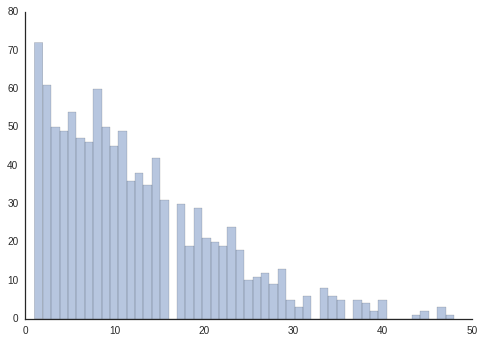

In [31]:
## How many different drug codes have been claimed per doctor?  Plot distribution

number_of_different_drug_codes_per_doctor = (by_npi > 0.0).sum(axis = 1)
g = sns.distplot(number_of_different_drug_codes_per_doctor, kde=False, bins=50)
#g.set(xlim=(0,500), ylim=(0, 60), xlabel='claims per drug B code', ylabel='counts')
sns.despine()

In [32]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1056
[t-SNE] Computed conditional probabilities for sample 1056 / 1056
[t-SNE] Mean sigma: 44.173597
[t-SNE] Iteration 25: error = 0.9673766, gradient norm = 0.0092206
[t-SNE] Iteration 50: error = 0.8920112, gradient norm = 0.0088044
[t-SNE] Iteration 75: error = 0.6276013, gradient norm = 0.0072393
[t-SNE] Iteration 100: error = 0.6041725, gradient norm = 0.0058408
[t-SNE] Error after 100 iterations with early exaggeration: 0.604172
[t-SNE] Iteration 125: error = 0.5379558, gradient norm = 0.0055912
[t-SNE] Iteration 150: error = 0.5134820, gradient norm = 0.0058858
[t-SNE] Iteration 175: error = 0.5142897, gradient norm = 0.0058520
[t-SNE] Iteration 200: error = 0.5136436, gradient norm = 0.0060303
[t-SNE] Iteration 200: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 200 iterations: 0.513644


In [61]:
by_npi.shape

(1056, 143)

In [62]:
len(X_embedded)

1056

## Read in Pubmed Authorship data

In [33]:
pubmed_count = pd.read_csv("pubmed_article_cnt.csv", usecols=range(1,6))
## convert npi to string
pubmed_count['npi'] = pubmed_count['npi'].astype('str')
pubmed_count.head()

,npi,last_first_mi,last_first,article_cnt_per_npi_with_mi,uids_per_npi_with_mi
0,1003019571,[],SEHGAL R,NaN,NaN
1,1003087768,[],BATUS M,NaN,NaN
2,1003166042,FINE HA,FINE H,148.0,"['26860632', '26643807', '26285768', '26194676', '25670220', '25605863', '25..."
3,1003805409,WILLIAMS SF,WILLIAMS S,27.0,"['26482109', '19471019', '19255322', '17199440', '16751789', '16331265', '15..."
4,1003807645,LUNIN SD,LUNIN S,0.0,[]


In [34]:
## substitute NaN with 0 in column article_cnt_per_npi_with_mi
pubmed_count['article_cnt_per_npi_with_mi'].fillna(0, inplace=True)
pubmed_count.head()

,npi,last_first_mi,last_first,article_cnt_per_npi_with_mi,uids_per_npi_with_mi
0,1003019571,[],SEHGAL R,0.0,NaN
1,1003087768,[],BATUS M,0.0,NaN
2,1003166042,FINE HA,FINE H,148.0,"['26860632', '26643807', '26285768', '26194676', '25670220', '25605863', '25..."
3,1003805409,WILLIAMS SF,WILLIAMS S,27.0,"['26482109', '19471019', '19255322', '17199440', '16751789', '16331265', '15..."
4,1003807645,LUNIN SD,LUNIN S,0.0,[]


In [35]:
## what is the maximum article count per npi?
print("max cnt: {0}".format(pubmed_count['article_cnt_per_npi_with_mi'].max()))

## mean article count per npi?
print("avg cnt: {0}".format(pubmed_count['article_cnt_per_npi_with_mi'].mean()))

## standard deviation of article counts?
print("standard deviation: {0}".format(pubmed_count['article_cnt_per_npi_with_mi'].std()))

max cnt: 144349.0
avg cnt: 215.85959985959985
standard deviation: 4102.227164078341


In [36]:
pubmed_count['article_cnt_per_npi_with_mi'] = pubmed_count['article_cnt_per_npi_with_mi'].astype('float')

The max count is clearly wrong.  Set likely faulty points (counts that are more than 1 s.d. from mean) to 0...

In [37]:
# the standard deviation
pubmed_cnt_sd = pubmed_count['article_cnt_per_npi_with_mi'].std()
pubmed_cnt_mean = pubmed_count['article_cnt_per_npi_with_mi'].mean()

pubmed_count.loc[pubmed_count.article_cnt_per_npi_with_mi > pubmed_cnt_mean+3*pubmed_cnt_sd, 
                 ['article_cnt_per_npi_with_mi', 'npi']] = 0

In [38]:
## check:
print("max cnt: {0}".format(pubmed_count['article_cnt_per_npi_with_mi'].max()))

max cnt: 11765.0


## Color physician points according to different characteristics

In [80]:
## create color scheme for each point based on (continuous) summary data label, 
## e.g. total_drug_services
color_codes = (pd.DataFrame({'npi':by_npi.index}).
               merge(summary[['npi', 
                              'total_drug_services',
                              'total_drug_unique_benes',
                              'total_drug_medicare_stnd_amt',
                              'total_submitted_chrg_amt'
                             ]]))
print(color_codes.shape)

color_codes = color_codes.merge(pubmed_count, on='npi', how='left')
print(color_codes.shape)
color_codes.head()

(1056, 5)
(1056, 9)


,npi,total_drug_services,total_drug_unique_benes,total_drug_medicare_stnd_amt,total_submitted_chrg_amt,last_first_mi,last_first,article_cnt_per_npi_with_mi,uids_per_npi_with_mi
0,1003019571,10351.0,56.0,131879.95,803873.00,[],SEHGAL R,0.0,NaN
1,1003807645,162635.0,405.0,1422596.46,7272566.00,LUNIN SD,LUNIN S,0.0,[]
2,1003809435,186282.0,225.0,1287789.14,5963296.00,FLORES MR,FLORES M,0.0,[]
3,1003828823,80453.0,310.0,1189756.27,3979628.58,RONNEN EA,RONNEN E,5.0,"['17083126', '16979716', '16832603', '16549825', '16192587']"
4,1003859679,147298.0,467.0,1178727.57,5486430.00,TAYLOR CW,TAYLOR C,32.0,"['26935984', '26530753', '23891098', '22911661', '21752480', '21376412', '19..."


In [41]:
color_codes.columns.values

array(['npi', 'total_drug_services', 'total_drug_unique_benes',
       'total_drug_medicare_stnd_amt', 'total_submitted_chrg_amt',
       'last_first_mi', 'last_first', 'article_cnt_per_npi_with_mi',
       'uids_per_npi_with_mi'], dtype=object)

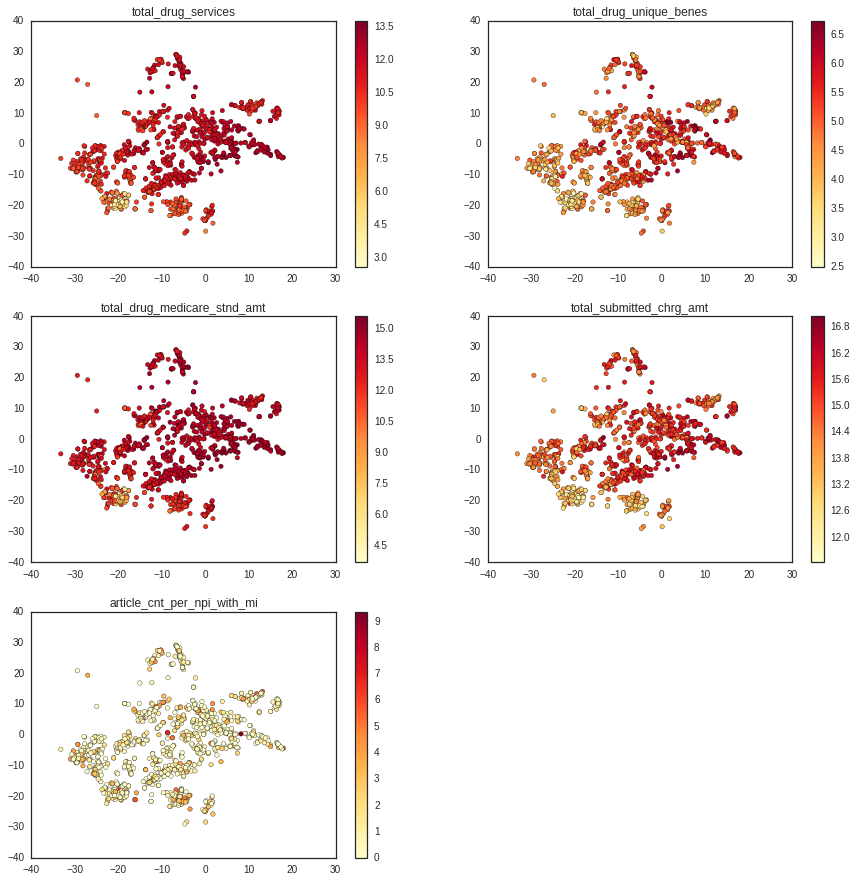

In [83]:
## tSNE plots color coded according to physician aggregate level characteristics, e.g. total drug services
## log scale

plt.rcParams['figure.figsize'] = (15.0, 15.0)

## color code values to run through
color_col_idx = list(range(1,5))+[7]
#color_col_idx = list(range(1,5))

for i, color_idx in enumerate(color_col_idx):
    plt.subplot(3,2, i+1)
    sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                     c=np.log(color_codes.iloc[:, color_idx] + 1.0), cmap='YlOrRd')
    plt.colorbar(sc)
    plt.title(color_codes.columns.values[color_idx])

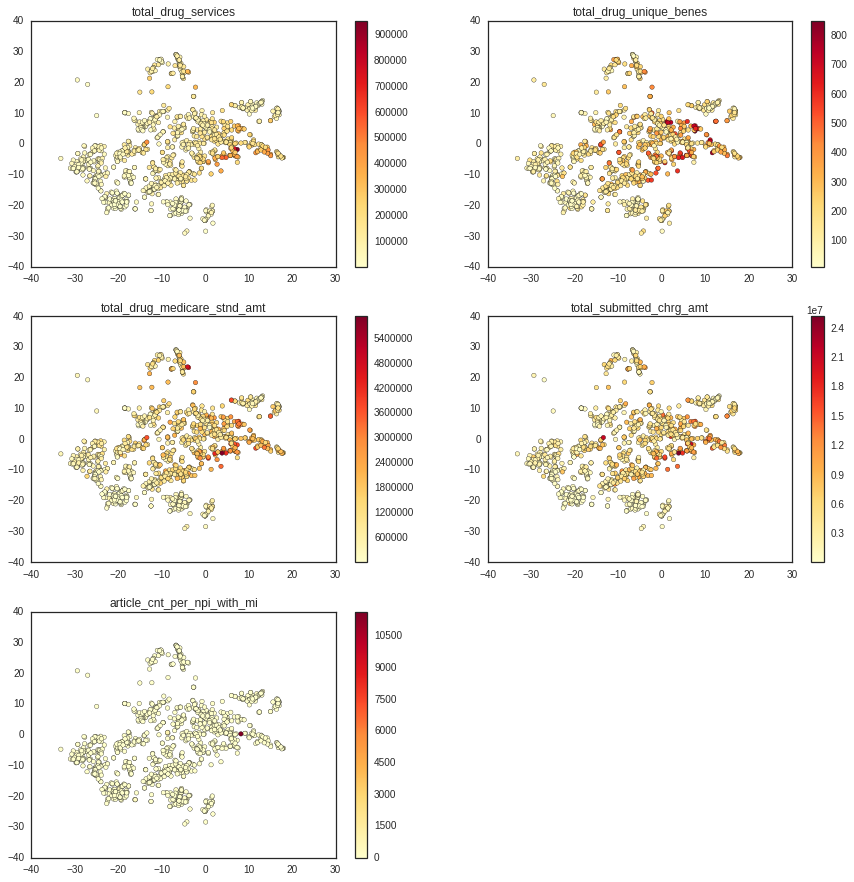

In [95]:
## tSNE plots color coded according to physician aggregate level characteristics, e.g. total drug services
## non log scale

plt.rcParams['figure.figsize'] = (15.0, 15.0)

## color code values to run through
color_col_idx = list(range(1,5))+[7]

for i, color_idx in enumerate(color_col_idx):
    plt.subplot(3,2,i+1)
    sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                     c= color_codes.iloc[:, color_idx], cmap='YlOrRd')
    plt.colorbar(sc)
    plt.title(color_codes.columns.values[color_idx])

## plot physicians with tSNE on *standardized* data

In [96]:
if con: 
    con.close()